In [1]:
import pandas as pd
import numpy as np
train_data_path = "E:/page ds/pages/ts_mixer/TS-Mixer/covTrain.csv" 
forecast_data_path = "E:/page ds/pages/ts_mixer/TS-Mixer/covForecast.csv" 

data_train = pd.read_csv(train_data_path)
forecast_data = pd.read_csv(forecast_data_path)


In [2]:
mi = data_train['index'].max()
forecast_data['index'] = [i + mi for i in forecast_data['index']]

forecast_data.set_index('index', inplace=True)
data_train.set_index('index', inplace=True)

Mamy tutaj komfortowa sytuację ponieważ od razu posiadamy dane podzielone na zbiór uczący i testowy. W drugiej kolejności należy dopisać dane odnośnie prognoz modelami zbudowanymi już w Pythonie tj. Prophet oraz LSTM.

In [3]:
#poniżej kody, które zapisywały dane do plików wyjsciowych: muszę teraz z nich wczytać odpowiednie dane
#pd.DataFrame(testPredict).to_csv("E:/page ds/pages/ts_mixer/TS-Mixer/CovidLSTMtest.csv")
#pd.DataFrame(trainPredict).to_csv("E:/page ds/pages/ts_mixer/TS-Mixer/CovidLSTMtrain.csv")  # tutaj brakuje pierwszego elementu, należy go uzupełnić
#CovidProphet.to_csv("E:/page ds/pages/ts_mixer/TS-Mixer/CovidProphet.csv") 

CovidLSTMtest = pd.read_csv("E:/page ds/pages/ts_mixer/TS-Mixer/CovidLSTMtest.csv")
CovidLSTMtrain = pd.read_csv("E:/page ds/pages/ts_mixer/TS-Mixer/CovidLSTMtrain.csv")
CovidProphet = pd.read_csv("E:/page ds/pages/ts_mixer/TS-Mixer/CovidProphet.csv")

CovidLSTMtest.columns = ['index', 'LSTM_hat']
CovidLSTMtrain.columns = ['index', 'LSTM_hat']
# zwiększam jeszcze wartości indexu ponieważ brakuje pierwszego elementu z indexu, całość jest przesunięta o +1
CovidLSTMtrain['index'] = [i + 1 for i in CovidLSTMtrain['index']]
CovidProphet.columns = ['index', 'Prophet_hat']

#wrzucam indexy
CovidProphet.set_index('index', inplace=True)
CovidLSTMtest.set_index('index', inplace=True)
CovidLSTMtrain.set_index('index', inplace=True)

import numpy as np
CovidLSTMtest.index = list(np.arange(713,727))

Uzupełniam o pozostałe kolumny z innymi modelami

In [4]:
data_train = data_train.join(CovidLSTMtrain)
#uzupełniam ostatnią wartość, której brakuje poprzez skopiowanie poprzedniej
data_train.at[712,'LSTM_hat'] = data_train.at[711,'LSTM_hat']
forecast_data = forecast_data.join(CovidLSTMtest)

In [5]:
forecast_data

,przypadki,Arima_lag1,Arima_bc,Arima_auto,LSTM_hat
index,,,,,
713,1410,2034.274742,2241.412268,1964.068297,598.8797
714,1541,1673.768116,1578.484464,1703.532761,975.5389
715,1676,1676.835701,988.593956,1828.390892,1326.2167
716,1833,1384.564595,665.417703,1950.741362,1652.9352
717,335,456.915837,710.315523,2070.634537,1957.5258
718,278,579.536340,945.997682,2188.119768,2241.6536
719,2703,1635.080261,1346.599938,2303.245417,2506.8350
720,2424,1857.087225,1491.898336,2416.058874,2754.4534
721,2504,1461.896915,1348.069793,2526.606577,2985.7754


In [6]:
CovidProphet.index = list(np.arange(1,727))
data_train = data_train.join(CovidProphet)
forecast_data = forecast_data.join(CovidProphet)

In [7]:
data_train.isnull().sum()

przypadki      0
Arima_lag1     0
Arima_bc       0
Arima_auto     0
LSTM_hat       0
Prophet_hat    0
dtype: int64

In [8]:
forecast_data.isnull().sum()

przypadki      0
Arima_lag1     0
Arima_bc       0
Arima_auto     0
LSTM_hat       0
Prophet_hat    0
dtype: int64

Skoro mamy dane to przystępuję do głównej części przedstawienia tj zbudowanie miksera

In [9]:
X = data_train[['Arima_lag1','Arima_bc', 'Arima_auto','LSTM_hat','Prophet_hat']]
y = data_train['przypadki']
X_forecast = forecast_data[['Arima_lag1','Arima_bc', 'Arima_auto','LSTM_hat','Prophet_hat']]
y_forecast = forecast_data['przypadki']



W ćwiczeniu tym wykorzystam kilka różnych mikserów: regresję logistyczną, wzmacnianie gradientowe, AdaBoost
Najpierw Regresja

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

LinearRegression()

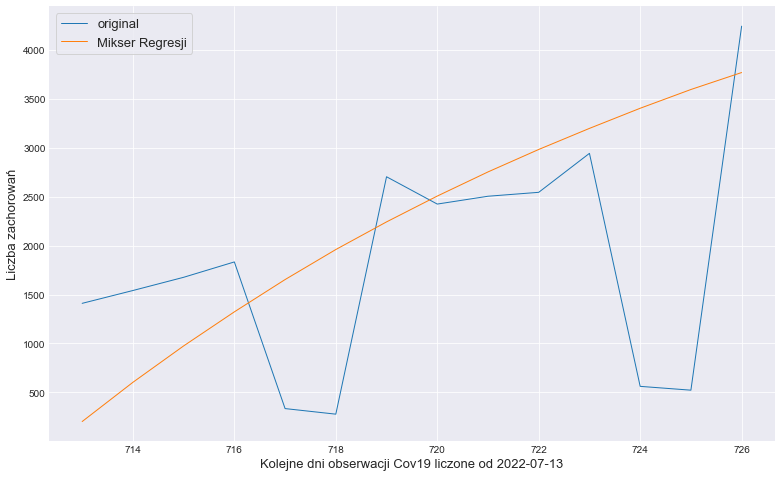

In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')  # https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

predykcja_reg = pd.DataFrame(model.predict(X_forecast))
predykcja_reg.index = y_forecast.index

# plot baseline and predictions
plt.figure(figsize = (13,8))
plt.plot(y_forecast, linewidth=1)
plt.plot(predykcja_reg, linewidth=1)
plt.legend(["Dane rzeczywiste", "Mikser Regresji"], loc=0, frameon=True, prop={'size': 13})
plt.xlabel('Kolejne dni obserwacji Cov19 liczone od 2022-07-13', fontsize=13)
plt.ylabel('Liczba zachorowań', fontsize=13)
#plt.savefig(r'E:\page ds\pages\ts_covid19\LSTM_test.png' , format="png", dpi=300)
plt.show()



W drugiej kolejności modele ze wzmacnianiem: AdaBoost - skrót od Adaptive boosting. Jest to predyktor z grupy modeli Wzmacniających (ang. boosting, pierwotnie zwane wzmacnianiem hipotezy - ang. hypothesis boosting). Model ten jest oparty na zasadzie wzmacniania błędów poprzednika. Dokładnie, budujemy model bazowy np. drzewo decyzyjne. Następnie wykorzystujemy go do przygotowania prognoz dla zbioru uczącego. Następnie algorytm zwiększa względną wagę dla nieprawidłowo sklasyfikowanych próbek.  Następnie trenujemy kolejny klasyfikator za pomocą zaktualizowanych wag itd. 

In [15]:
from sklearn.ensemble import AdaBoostRegressor

AdaRegr = AdaBoostRegressor(random_state=0, n_estimators=100)
AdaRegr.fit(X.to_numpy(), y.to_numpy())


AdaBoostRegressor(n_estimators=100, random_state=0)

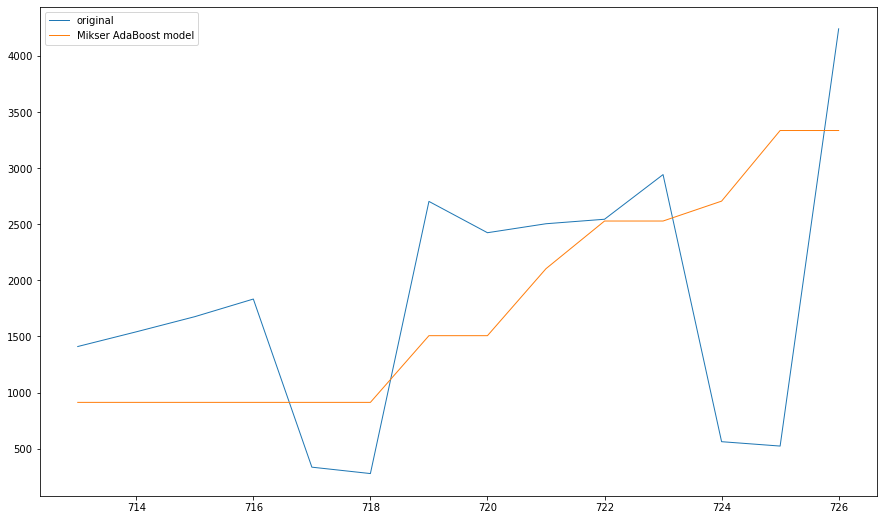

In [24]:
predykcja_ada = pd.DataFrame(AdaRegr.predict(X_forecast.to_numpy()))
predykcja_ada.index = y_forecast.index

# plot baseline and predictions
plt.figure(figsize = (15,9))
plt.plot(y_forecast, linewidth=1)
plt.plot(predykcja_ada, linewidth=1)
plt.legend(["Dane rzeczywiste", "Mikser AdaBoost model"], loc=0, frameon=True)
#plt.savefig(r'E:\page ds\pages\ts_covid19\LSTM_test.png' , format="png", dpi=300)
plt.show()

Następnie przetestuję model wzmacniania gradientowego. Podobnie jak AdaBoost algorytm dodaje do zespołu kolejne modele w sposób sekwencyjny. 
Róznica polega na tym, że w tym modelu nie dokonujemy aktualizacji wag po każdym przebiegu modelu lecz próbujemy zbudować predyktor dla błędu resztkowego (ang. residual error) popełnionego przez poprzedni predyktor. 


In [21]:
from sklearn.ensemble import GradientBoostingRegressor
gbreg = GradientBoostingRegressor(max_depth=3, n_estimators=200, learning_rate=0.1)
#gbreg = GradientBoostingRegressor(random_state=0)
gbreg.fit(X.to_numpy(), y.to_numpy())



GradientBoostingRegressor(n_estimators=200)

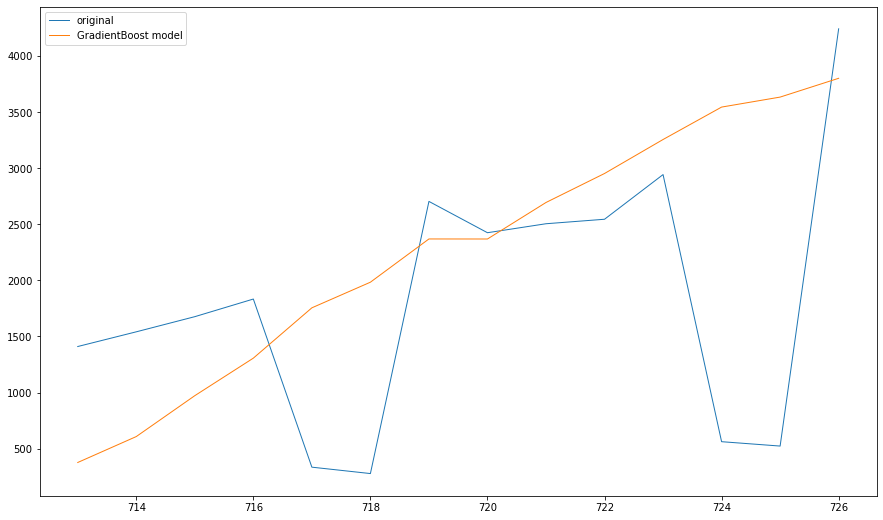

In [25]:
predykcja_gbr = pd.DataFrame(gbreg.predict(X_forecast.to_numpy()))
predykcja_gbr.index = y_forecast.index

# plot baseline and predictions
plt.figure(figsize = (15,9))
plt.plot(y_forecast, linewidth=1)
plt.plot(predykcja_gbr, linewidth=1)
plt.legend(["Dane rzeczywiste", "GradientBoost model"], loc=0, frameon=True)
#plt.savefig(r'E:\page ds\pages\ts_covid19\LSTM_test.png' , format="png", dpi=300)
plt.show()

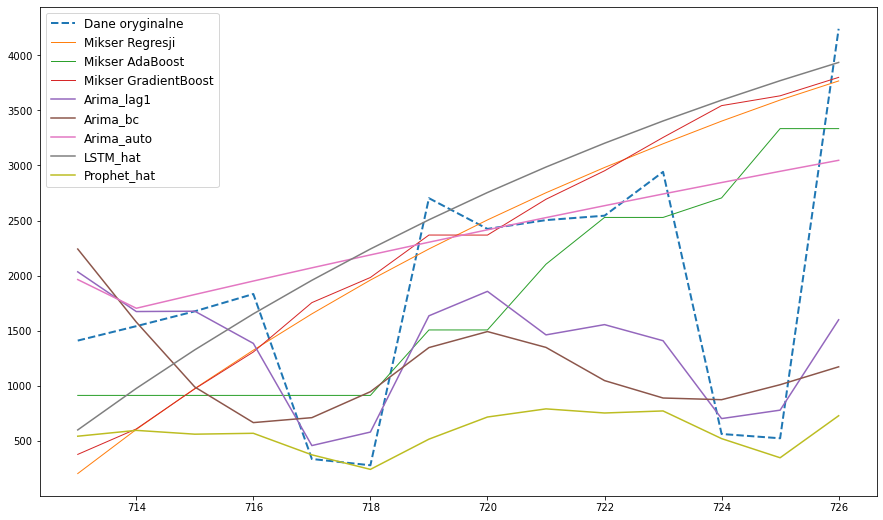

In [39]:

# plot baseline and predictions
plt.figure(figsize = (15,9))
plt.plot(y_forecast, linewidth=2, linestyle='dashed')
plt.plot(predykcja_reg, linewidth=1)
plt.plot(predykcja_ada, linewidth=1)
plt.plot(predykcja_gbr, linewidth=1)
plt.plot(X_forecast)
plt.legend(["Dane rzeczywiste","Mikser Regresji", "Mikser AdaBoost", "Mikser GradientBoost"] + list(X_forecast.columns), 
           loc=0, frameon=True,  prop={'size': 12})
#plt.savefig(r'E:\page ds\pages\ts_covid19\LSTM_test.png' , format="png", dpi=300)
plt.show()

In [38]:
list(X_forecast.columns)

['Arima_lag1', 'Arima_bc', 'Arima_auto', 'LSTM_hat', 'Prophet_hat']

To sprawdźmy jaką moc mają nasze modele zarówno na zbiorze trenującym jak i na prognozowanym. W tym celu wykorzystam najbardziej do tego odpowiednią metrykę jaką będzie MAE

In [53]:
from sklearn.metrics import mean_absolute_error

metryki = pd.DataFrame(columns=["MikserRegresji", "MikserAdaBoost", "MikserGradientBoost"] + list(X_forecast.columns),
                      index=['traint', 'forecast'])

In [63]:
metryki.at['forecast', 'MikserRegresji'] = mean_absolute_error(y_forecast, predykcja_reg)
metryki.at['forecast', 'MikserAdaBoost'] = mean_absolute_error(y_forecast, predykcja_ada)
metryki.at['forecast', 'MikserGradientBoost'] = mean_absolute_error(y_forecast, predykcja_gbr)
metryki.at['forecast', 'Arima_lag1'] = mean_absolute_error(y_forecast, X_forecast['Arima_lag1'])
metryki.at['forecast', 'Arima_bc'] = mean_absolute_error(y_forecast, X_forecast['Arima_bc'])
metryki.at['forecast', 'Arima_auto'] = mean_absolute_error(y_forecast, X_forecast['Arima_auto'])
metryki.at['forecast', 'LSTM_hat'] = mean_absolute_error(y_forecast, X_forecast['LSTM_hat'])
metryki.at['forecast', 'Prophet_hat'] = mean_absolute_error(y_forecast, X_forecast['Prophet_hat'])


In [64]:
metryki

,MikserRegresji,MikserAdaBoost,MikserGradientBoost,Arima_lag1,Arima_bc,Arima_auto,LSTM_hat,Prophet_hat
traint,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forecast,1016.05106,916.250711,1011.011448,704.716933,1044.925604,803.990019,1014.61865,1255.251026


In [65]:
#należy dodać jeszcze metryki dla zbioru uczącego
metryki.at['traint', 'MikserRegresji'] = mean_absolute_error(y, model.predict(X))
metryki.at['traint', 'MikserAdaBoost'] = mean_absolute_error(y, AdaRegr.predict(X.to_numpy()))
metryki.at['traint', 'MikserGradientBoost'] = mean_absolute_error(y, gbreg.predict(X.to_numpy()))
metryki.at['traint', 'Arima_lag1'] = mean_absolute_error(y, X['Arima_lag1'])
metryki.at['traint', 'Arima_bc'] = mean_absolute_error(y, X['Arima_bc'])
metryki.at['traint', 'Arima_auto'] = mean_absolute_error(y, X['Arima_auto'])
metryki.at['traint', 'LSTM_hat'] = mean_absolute_error(y, X['LSTM_hat'])
metryki.at['traint', 'Prophet_hat'] = mean_absolute_error(y, X['Prophet_hat'])





In [66]:
metryki

,MikserRegresji,MikserAdaBoost,MikserGradientBoost,Arima_lag1,Arima_bc,Arima_auto,LSTM_hat,Prophet_hat
traint,35.283346,490.969459,26.513248,4221.278426,1396.183714,1571.928598,464.170837,1910.378613
forecast,1016.05106,916.250711,1011.011448,704.716933,1044.925604,803.990019,1014.61865,1255.251026
